In [1]:
#необходимые пакеты 
import ee, geemap, os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import scipy

In [2]:
ee.Initialize()

In [3]:
region_boundary = geemap.geojson_to_ee('data/budenovsk_district_boundaries.geojson')

Budenovsk = geemap.Map(zoom = 10)

Budenovsk.centerObject(region_boundary)

Budenovsk.addLayer(region_boundary ,{'color' : "FF0000"}, 'Границы региона' )

Budenovsk

Map(center=[44.745544055004785, 44.14114333519604], controls=(WidgetControl(options=['position'], widget=HBox(…

In [4]:
#геометрии
Archangelskoe = gpd.read_file('data/archangelskoe_wgs84.geojson' )
Praskoveya = gpd.read_file('Data/praskoveya_wgs84.geojson')

Archangelskoe['type'] = 'PP'
Praskoveya['type'] = 'TT'

geometry_df = Praskoveya.append(Archangelskoe.iloc[:,2:])


geometry_df['number'] = [i for i in range(0,geometry_df.shape[0])]

geometry_df_geemap = geemap.geopandas_to_ee(geometry_df)
geometry_df

,id,_mean,culture,name,cultutre19,geometry,type,culture18,culture19,crop2018,crop2019,number
0,21.0,0.067364,пропашная,Прасковейское,par,"POLYGON ((44.25443 44.69242, 44.25624 44.69448...",TT,NaN,NaN,NaN,NaN,0
1,22.0,0.242672,озимая,Прасковейское,None,"POLYGON ((44.29948 44.66839, 44.28994 44.67340...",TT,NaN,NaN,NaN,NaN,1
2,19.0,0.170963,пропашная,Прасковейское,oz.psen.trad,"POLYGON ((44.29994 44.66801, 44.31107 44.67854...",TT,NaN,NaN,NaN,NaN,2
3,20.0,0.166594,пропашная,Прасковейское,oz.psen.trad,"POLYGON ((44.30987 44.66254, 44.32131 44.67360...",TT,NaN,NaN,NaN,NaN,3
4,25.0,0.185554,пропашная,Прасковейское,oz.psen.trad,"POLYGON ((44.32021 44.65721, 44.33200 44.66846...",TT,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,"POLYGON ((44.22878 44.55224, 44.22557 44.55407...",PP,oz.yachmen,goroh,NaN,NaN,265
146,NaN,NaN,NaN,NaN,NaN,"POLYGON ((44.16633 44.60854, 44.17036 44.60653...",PP,oz.pshenica,podsoln,NaN,NaN,266
147,NaN,NaN,NaN,NaN,NaN,"POLYGON ((44.15963 44.62325, 44.16744 44.61913...",PP,oz.pshenica,podsoln,NaN,NaN,267
148,NaN,NaN,NaN,NaN,NaN,"POLYGON ((44.12099 44.64406, 44.13320 44.63767...",PP,None,None,NaN,NaN,268


##### MODIS NDVI

In [6]:
MODIS_NDVI = ee.ImageCollection('MODIS/006/MOD13Q1').filterBounds(region_boundary).filterDate('2018-09-01', '2019-09-01').select('NDVI')

In [10]:

collection_size = MODIS_NDVI.size().getInfo() # размер коллекции

MODIS_NDVI_list = MODIS_NDVI.toList(collection_size)


NDVI_MODIS_COLLECTION = ee.Image().reproject(crs= 'SR-ORG:6974' , crsTransform = [231.656358264,0,-20015109.354,0,-231.656358264,10007554.677])


time_lst = [] # лист с датами NDVI 
print(time_lst)
for i in range(collection_size): 
    img = ee.Image(MODIS_NDVI_list.get(i))
    time = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    
    time_lst.append(time)
    
    img = ee.Image(MODIS_NDVI_list.get(i)).select('NDVI').multiply(0.0001).rename(time)


    NDVI_MODIS_COLLECTION = NDVI_MODIS_COLLECTION.addBands(img) #датафрейм с каналами


    
print(time_lst)

df = NDVI_MODIS_COLLECTION.select(time_lst).sampleRegions(geometry_df_geemap)

#geemap.ee_export_vector(df, filename='C:/Users/User/Google Диск/python_notebooks/Archangelskoe_NDTI_project/Data/NDVI_2018_2019_modis.csv')
#скачиваем датафрейм с данными NDVI

[]
['2018-09-14', '2018-09-30', '2018-10-16', '2018-11-01', '2018-11-17', '2018-12-03', '2018-12-19', '2019-01-01', '2019-01-17', '2019-02-02', '2019-02-18', '2019-03-06', '2019-03-22', '2019-04-07', '2019-04-23', '2019-05-09', '2019-05-25', '2019-06-10', '2019-06-26', '2019-07-12', '2019-07-28', '2019-08-13', '2019-08-29']


In [32]:
NDVI_2018_2019 = pd.read_csv('Data/NDVI_2018_2019_modis.csv')
NDVI_2018_2019 = NDVI_2018_2019.drop(["culture",'name','_mean',"cultutre19", 'id','system:index' ], 1)

Данные готовы
первый шаг это проверить на нормальность 

In [40]:
stat_NDVI = NDVI_2018_2019
stat_NDVI

def norm_test_result(x):
    if scipy.stats.kstest(x, 'norm')[1] < 0.05:
        return('распределение отличается от нормального')
    else:
        return('распределение нормальное')
    
normality = stat_NDVI.groupby(["number",'type']).aggregate([norm_test_result]).reset_index()

In [41]:
for i in range((normality.shape[1])):
    print(normality.iloc[:,i].value_counts())

0      1
185    1
171    1
172    1
173    1
      ..
95     1
96     1
97     1
98     1
269    1
Name: (number, ), Length: 270, dtype: int64
PP    150
TT    120
Name: (type, ), dtype: int64
распределение отличается от нормального    247
распределение нормальное                    23
Name: (2019-01-17, norm_test_result), dtype: int64
распределение отличается от нормального    262
распределение нормальное                     8
Name: (2019-02-18, norm_test_result), dtype: int64
распределение отличается от нормального    243
распределение нормальное                    27
Name: (2019-01-01, norm_test_result), dtype: int64
распределение отличается от нормального    254
распределение нормальное                    16
Name: (2019-02-02, norm_test_result), dtype: int64
распределение отличается от нормального    265
распределение нормальное                     5
Name: (2019-06-10, norm_test_result), dtype: int64
распределение отличается от нормального    260
распределение нормальное            

короче везде не нормальное распределение, можно смело сказать что берем медиану 

In [42]:
median_NDVI = stat_NDVI.groupby(["number",'type' ]).aggregate([np.median]).reset_index()

In [63]:
col_names = []
for i in range(median_NDVI.shape[1]):
    col_names.append((median_NDVI.columns[i][0]))
median_NDVI.columns = col_names
median_NDVI

,number,type,2019-01-17,2019-02-18,2019-01-01,2019-02-02,2019-06-10,2018-11-01,2018-12-03,2019-07-12,...,2019-07-28,2018-09-30,2019-06-26,2019-08-29,2019-03-06,2019-04-07,2019-05-09,2018-12-19,2018-10-16,2018-11-17
0,0,TT,0.04385,0.19470,-0.01610,0.11335,0.20310,0.28960,0.3067,0.19400,...,0.20030,0.35950,0.20410,0.20050,0.21255,0.22900,0.26120,0.08055,0.34215,0.26215
1,1,TT,-0.00600,0.19145,-0.01940,0.19345,0.35410,0.19850,0.2460,0.26060,...,0.27110,0.20230,0.24090,0.33590,0.21610,0.40190,0.81200,0.05255,0.20250,0.21030
2,2,TT,-0.01220,0.19140,-0.01660,0.13510,0.54530,0.20260,0.2465,0.28090,...,0.29660,0.20330,0.27680,0.42240,0.19630,0.29750,0.77330,0.05830,0.19800,0.22430
3,3,TT,-0.01300,0.18560,-0.01895,0.16230,0.55790,0.19395,0.2445,0.27120,...,0.26700,0.21770,0.27940,0.38100,0.19700,0.30180,0.78710,0.06040,0.20180,0.16720
4,4,TT,-0.01420,0.18740,-0.02280,0.16390,0.56890,0.21450,0.2574,0.26050,...,0.25130,0.21050,0.29170,0.35870,0.20610,0.32220,0.82260,0.06010,0.21240,0.13820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,265,PP,-0.02020,0.19070,-0.00540,0.02690,0.32840,0.18910,0.2710,0.23850,...,0.22100,0.20680,0.21720,0.21950,0.20920,0.21530,0.69200,0.04600,0.19220,0.12870
266,266,PP,-0.00500,0.20455,0.00020,0.19235,0.65365,0.21005,0.2235,0.58780,...,0.30920,0.22435,0.62265,0.23690,0.21730,0.23505,0.29380,0.11320,0.21920,0.17885
267,267,PP,0.01740,0.19790,0.00250,0.19390,0.68060,0.19310,0.2080,0.66120,...,0.28040,0.21330,0.70070,0.23370,0.22420,0.21720,0.29890,0.13430,0.21070,0.16840
268,268,PP,0.15980,0.19840,0.00570,0.25745,0.45380,0.21480,0.2367,0.22085,...,0.27695,0.20390,0.26815,0.24050,0.20370,0.28285,0.84155,0.20770,0.19265,0.20185


переходим к кластеризации
но в начале следует все таки пройтись МГК по данным и посмотреть как они выглядят

Сначала можно создать методом гланвых компонент две компоненты
https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Data_Visualization_Iris_Dataset_Blog.ipynb ссылка
https://plotly.com/python/pca-visualization/ тут еще про то как добавить единичные вектора

In [65]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [93]:
columns_to_pca = col_names[2:]
x = median_NDVI.loc[:,columns_to_pca].values

y = median_NDVI.loc[:,["type"]].values

In [94]:
x = StandardScaler().fit_transform(x) #стандартизация данных



In [98]:
pca = PCA(n_components = 2) #задали колличество компонет
principalComponents = pca.fit_transform(x) # трансформировали датафрейм
principal_NDVI = pd.DataFrame(data = principalComponents , columns = ['PC_1', 'PC_2']) #создали датасет 

In [99]:
principal_NDVI['type'] = y # добавили к датасету целевую переменную 

<AxesSubplot:xlabel='PC_1', ylabel='PC_2'>

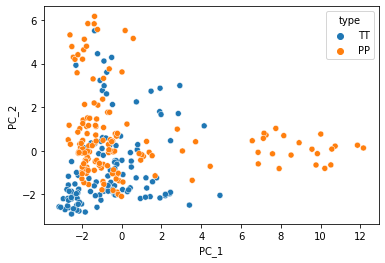

In [100]:
sns.scatterplot(x = 'PC_1', y = 'PC_2', hue = 'type', data = principal_NDVI)

In [101]:
median_NDVI[['PC_1', 'PC_2']] = principal_NDVI[['PC_1', 'PC_2']]

In [112]:
from sklearn.cluster import KMeans, SpectralClustering

from sklearn.metrics import silhouette_samples, silhouette_score


K-means 

In [120]:
TT = median_NDVI[median_NDVI.type == "TT"] #просто отобрал для традиционки данные 

x = TT.loc[:,columns_to_pca].values #отобрали в нужные данные

x = StandardScaler().fit_transform(x) #стандартизация данных

(120, 23)

In [123]:
km = KMeans(n_clusters=3, max_iter=100) #параметры k-means

km.fit(x) # обучение модели



KMeans(max_iter=100, n_clusters=3)

In [124]:
km.labels_

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 0, 1, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 0, 0, 2, 1, 1, 0, 0,
       2, 2, 0, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 1, 1, 2, 1, 0, 2, 2, 0, 1, 1, 1, 2, 2, 2, 0, 0, 2, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 2, 2])

<ipython-input-126-8259d5cc316b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TT["clusters"] = km.labels_


<AxesSubplot:xlabel='PC_1', ylabel='PC_2'>

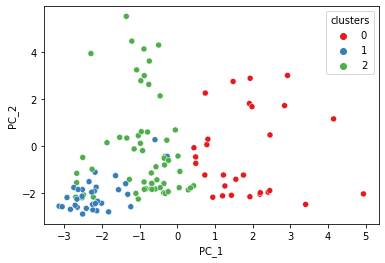

In [126]:
TT["clusters"] = km.labels_
sns.scatterplot(x = 'PC_1', y = 'PC_2', hue = "clusters",   palette='Set1',data = TT)

In [118]:
long_clustered_df = clustered_df.melt(id_vars='clusters',var_name='date', value_name='value' )

,number,type,2019-01-17,2019-02-18,2019-01-01,2019-02-02,2019-06-10,2018-11-01,2018-12-03,2019-07-12,...,2019-06-26,2019-08-29,2019-03-06,2019-04-07,2019-05-09,2018-12-19,2018-10-16,2018-11-17,PC_1,PC_2
0,0,TT,0.04385,0.19470,-0.01610,0.11335,0.2031,0.28960,0.3067,0.1940,...,0.2041,0.20050,0.21255,0.2290,0.2612,0.08055,0.34215,0.26215,-0.669701,-1.606661
1,1,TT,-0.00600,0.19145,-0.01940,0.19345,0.3541,0.19850,0.2460,0.2606,...,0.2409,0.33590,0.21610,0.4019,0.8120,0.05255,0.20250,0.21030,-0.457426,2.123845
2,2,TT,-0.01220,0.19140,-0.01660,0.13510,0.5453,0.20260,0.2465,0.2809,...,0.2768,0.42240,0.19630,0.2975,0.7733,0.05830,0.19800,0.22430,-0.886223,4.120138
3,3,TT,-0.01300,0.18560,-0.01895,0.16230,0.5579,0.19395,0.2445,0.2712,...,0.2794,0.38100,0.19700,0.3018,0.7871,0.06040,0.20180,0.16720,-1.080742,3.229955
4,4,TT,-0.01420,0.18740,-0.02280,0.16390,0.5689,0.21450,0.2574,0.2605,...,0.2917,0.35870,0.20610,0.3222,0.8226,0.06010,0.21240,0.13820,-0.968238,2.767105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,115,TT,0.08675,0.18770,-0.01010,0.07320,0.1888,0.22660,0.1924,0.1969,...,0.1806,0.19245,0.19890,0.1914,0.2363,0.05790,0.23940,0.19690,-2.529211,-2.148873
116,116,TT,0.10160,0.20000,-0.01770,0.09320,0.2080,0.25390,0.2994,0.2113,...,0.1894,0.19540,0.20360,0.2051,0.2394,0.04810,0.29390,0.23520,-1.562605,-1.870262
117,117,TT,-0.00610,0.20270,-0.01720,0.03680,0.5488,0.19320,0.2551,0.1879,...,0.2635,0.19020,0.25130,0.5455,0.8720,0.02940,0.20150,0.20850,-0.340374,-0.815795
118,118,TT,-0.00030,0.22010,-0.00900,0.05350,0.4293,0.21030,0.2958,0.1775,...,0.1799,0.18060,0.28450,0.6730,0.8783,0.02620,0.21180,0.18250,0.351533,-1.794597


In [127]:
# получился пооолный хаос дома можно покопать и доделать

https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a ссылка на статью по K-means